In [27]:
!pip install mido
!pip install pygame
!pip install music21
!pip install scikit-learn==1.3.0

In [1]:
# import some useful libraries
import glob, nltk, joblib
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import metrics

from PIL import Image
from tqdm.notebook import tqdm

from sklearn.feature_extraction.text import CountVectorizer

from music21 import midi
from plugins.midi2img import midi2img
from plugins.img2midi import img2midi
from IPython.display import clear_output

# Load In museGAN dataset for visualization purposes
It turned out that the people at museGAN is leveraging midi -> image conversion. The image consisted of bar of a multi track piano roll. From the below image, the horizontal represent time and the vericle represent the instrument used. In this dataset the instrument are layered from bottom to top as piano, strings, guitar, drums, bass.


In [2]:
# download the punkt tokenizer from nltk to tokenize the piece caption
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ktrin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Construction of museGAN
## External Data Source
For whatever reason, if we wanted to perform GAN modeling, we can leverage conversion of MIDI data to that of the piano roll. Download the data from piano repo in README and start performing the things below. [Convert-MIDI-TO-NP-ARRAY](https://medium.com/analytics-vidhya/convert-midi-file-to-numpy-array-in-python-7d00531890c)

# Caption Processing

In [3]:
MAX_SEQ_LENGTH = 20 # 18 + start, end
EMBED_DIM = 100 
MAX_VOCAB_SIZE = 20000

In [4]:
# load in the metadata
# create a list of captions that concatenate the piece description and arousal
# lower case te caption list
midi_meta = pd.read_csv('../data/piano-labelled/labelled_piano_midi_metadata.csv')
midi_meta['caption_list'] = midi_meta['piece_description'].str.lower()+ ". " + midi_meta['piece_arousal'].str.lower()
midi_meta

,piece_id,piece_description,piece_arousal,piece_name,midi_file,caption_list
0,0,very upbeat,Delighted,Lurking In The Darkness,Final Fantasy_PS1_Final Fantasy VII_Lurking In...,very upbeat. delighted
1,1,I could tell the valence of the example was in...,Valence started out moderately negative and pr...,Lurking In The Darkness,Final Fantasy_PS1_Final Fantasy VII_Lurking In...,i could tell the valence of the example was in...
2,2,For a second I thought this piece was going to...,This piece seemed to have a positive valence t...,Lurking In The Darkness,Final Fantasy_PS1_Final Fantasy VII_Lurking In...,for a second i thought this piece was going to...
3,3,Bouncy and fun,Kind of sparatic,Lurking In The Darkness,Final Fantasy_PS1_Final Fantasy VII_Lurking In...,bouncy and fun. kind of sparatic
4,4,nice,nice,Lurking In The Darkness,Final Fantasy_PS1_Final Fantasy VII_Lurking In...,nice. nice
...,...,...,...,...,...,...
6100,6100,It started off slowly but happy and then built...,Seemed to remain consistent almost like it was...,One Winged Angel,Final Fantasy_PS1_Final Fantasy VII_One Winged...,it started off slowly but happy and then built...
6101,6101,This starts off a certain way then changes in ...,This is nostalgic because I recognize this and...,One Winged Angel,Final Fantasy_PS1_Final Fantasy VII_One Winged...,this starts off a certain way then changes in ...
6102,6102,The piece begins slow in tempo and then become...,"The beginning rhythm sounds suspenseful, makin...",One Winged Angel,Final Fantasy_PS1_Final Fantasy VII_One Winged...,the piece begins slow in tempo and then become...
6103,6103,started slow but picked up.,I feel it stayed the same,One Winged Angel,Final Fantasy_PS1_Final Fantasy VII_One Winged...,started slow but picked up. . i feel it stayed...


In [5]:
# build a vocabulary using sklearn count vectorizer to create a vocab from the most frequent words
input_captions = []
max_caption_length = -1 

for caption in tqdm(midi_meta['caption_list'].values):
    tokenized_caption = nltk.word_tokenize(caption, language='english')

    if len(tokenized_caption) > max_caption_length:
        max_caption_length = len(tokenized_caption)

    caption = (' '.join(tokenized_caption)).lower()
    input_captions.append(caption)


vectorizer = CountVectorizer(max_features=MAX_VOCAB_SIZE)
vectorizer.fit(input_captions)
vocab = vectorizer.get_feature_names_out()
MAX_VOCAB_SIZE = len(vocab)

  0%|          | 0/6105 [00:00<?, ?it/s]

In [6]:
# turn vocab into a dictionary of words and token id
# replace some words with special tokens like start/end/unk
# if the caption is too short, pad it with <pad> token
id_vocab_dict = {}
vocab_id_dict = {}

for sid, svocab in enumerate(vocab):
    id_vocab_dict[sid] = svocab
    vocab_id_dict[svocab] = sid

id_vocab_dict[MAX_VOCAB_SIZE] = "<unk>"
id_vocab_dict[MAX_VOCAB_SIZE + 1] = "<start>"
id_vocab_dict[MAX_VOCAB_SIZE + 2] = "<end>"
id_vocab_dict[MAX_VOCAB_SIZE + 3] = "<pad>"

vocab_id_dict["<unk>"] = MAX_VOCAB_SIZE
vocab_id_dict["<start>"] = MAX_VOCAB_SIZE + 1
vocab_id_dict["<end>"] = MAX_VOCAB_SIZE + 2
vocab_id_dict["<pad>"] = MAX_VOCAB_SIZE + 3

In [7]:
# tokenization - take the input caption and tokenize it
# declare a max sequence length 
def convert_text_to_data(texts, 
                         vocab_id_dict, 
                         max_length=20, 
                         type=None):
    """
        Function to convert text based data into tokenized data with proper padding
    """

    processed_data = []
    for text_num, text in enumerate(texts):
        sentence_ids = []

        # split the sentence into token
        # use the vocab to turn the word token into number
        for token in text.split():
            if token in vocab_id_dict.keys():
                sentence_ids.append(vocab_id_dict[token])
            else:
                sentence_ids.append(vocab_id_dict["<unk>"])

        vocab_size = len(vocab_id_dict.keys())

        # for decoder cases:
        # input sentence: <start>, [tokenize words from vocab], <end>, padded with <unk>
        # ouput sentence has: [tokenize words from vocab], <end>, padded with <unk>
        if type == 'input_target':
            ids = ([vocab_size - 3] + sentence_ids + [vocab_size - 2] + [vocab_size - 1] * max_length)[:max_length]
        elif type == 'output_target':
            ids = (sentence_ids + [vocab_size - 2] + [vocab_size - 1] * max_length)[:max_length]
        processed_data.append(ids)

    return np.array(processed_data)


train_target_input_data = convert_text_to_data(input_captions,
                                                vocab_id_dict,
                                                type='input_target',
                                                max_length=MAX_SEQ_LENGTH)
len(train_target_input_data)

6105

In [8]:
# added the tokenized caption to the metadata
midi_meta['tokenized_captions'] = train_target_input_data.tolist()
midi_meta

,piece_id,piece_description,piece_arousal,piece_name,midi_file,caption_list,tokenized_captions
0,0,very upbeat,Delighted,Lurking In The Darkness,Final Fantasy_PS1_Final Fantasy VII_Lurking In...,very upbeat. delighted,"[3452, 3319, 3258, 3451, 762, 3453, 3454, 3454..."
1,1,I could tell the valence of the example was in...,Valence started out moderately negative and pr...,Lurking In The Darkness,Final Fantasy_PS1_Final Fantasy VII_Lurking In...,i could tell the valence of the example was in...,"[3452, 3451, 661, 3025, 3053, 3290, 2095, 3053..."
2,2,For a second I thought this piece was going to...,This piece seemed to have a positive valence t...,Lurking In The Darkness,Final Fantasy_PS1_Final Fantasy VII_Lurking In...,for a second i thought this piece was going to...,"[3452, 1220, 3451, 2627, 3451, 3078, 3074, 224..."
3,3,Bouncy and fun,Kind of sparatic,Lurking In The Darkness,Final Fantasy_PS1_Final Fantasy VII_Lurking In...,bouncy and fun. kind of sparatic,"[3452, 364, 138, 1262, 3451, 1686, 2095, 2820,..."
4,4,nice,nice,Lurking In The Darkness,Final Fantasy_PS1_Final Fantasy VII_Lurking In...,nice. nice,"[3452, 2044, 3451, 2044, 3453, 3454, 3454, 345..."
...,...,...,...,...,...,...,...
6100,6100,It started off slowly but happy and then built...,Seemed to remain consistent almost like it was...,One Winged Angel,Final Fantasy_PS1_Final Fantasy VII_One Winged...,it started off slowly but happy and then built...,"[3452, 1623, 2869, 2096, 2756, 413, 1374, 138,..."
6101,6101,This starts off a certain way then changes in ...,This is nostalgic because I recognize this and...,One Winged Angel,Final Fantasy_PS1_Final Fantasy VII_One Winged...,this starts off a certain way then changes in ...,"[3452, 3074, 2872, 2096, 3451, 468, 3366, 3061..."
6102,6102,The piece begins slow in tempo and then become...,"The beginning rhythm sounds suspenseful, makin...",One Winged Angel,Final Fantasy_PS1_Final Fantasy VII_One Winged...,the piece begins slow in tempo and then become...,"[3452, 3053, 2241, 304, 2751, 1510, 3031, 138,..."
6103,6103,started slow but picked up.,I feel it stayed the same,One Winged Angel,Final Fantasy_PS1_Final Fantasy VII_One Winged...,started slow but picked up. . i feel it stayed...,"[3452, 2869, 2751, 413, 2233, 3451, 3451, 3451..."


## Dataset Construction

In [ ]:
# read in music and prepare it in a list of notes
midis = []
for file in tqdm(glob.glob("../data/piano-labelled/midi/*.mid")):
    midis.append(file)

In [ ]:
# convert MIDI to image
# declare output path
output_path = "../data/piano-labelled/midi_img"

# instantiate a midi2img converter object
midi2img_obj = midi2img(output_path)

# for each midi file, convert it to image
for midi in tqdm(midis):
    data, metadata = midi2img_obj.convert_to_image(midi)
    for img_key in data.keys():
        try:
            img_path = output_path+"/"+midi.split("/")[-1].replace(".mid",f"_{img_key}.png")
            # print(img_path)
            img = Image.open(img_path)
            basewidth = 106
            hsize = 106
            img = img.resize((basewidth,hsize), Image.ANTIALIAS)
            img.save(img_path)
        except:
            print("Error in converting: "+img_path)
            pass

In [ ]:
# Dataset Construction
def access_images(path, metadata, num_images=float("inf")):
    """
        Fetch a defined number of images from a directory
        and return their normalized pixels arrays
        Inputs:
            path: path to the directory containing the images
            img_list: list of image names
            num_images: number of images to fetch
        Output:
            image_arr: pixel array of images
            img: the original image
    """
    pixels = {}
    imgs = []

    # construct a dictionary of empty lists with the song name
    for piece in tqdm(metadata['piece_name'].unique()):
        # if row['piece_name'] not in pixels.keys():
        #     pixels[row['piece_name']] = []
            
        # fetch all images from the directory
        i = 0
        for file in (glob.glob(f"{path}/*.png")):
            if i >= num_images:
                break
            try:
                img = Image.open(file, 'r')
                img = img.convert('1')
                pix = np.array(img.getdata())
                pix = pix.astype('float32')
                pix /= 255.0
                
                if piece in file:
                    if piece not in pixels.keys():
                        pixels[piece] = [pix.reshape(106,106,1)]
                    else:
                        pixels[piece].append(pix.reshape(106,106,1))
                # pixels.append(pix.reshape(106,106,1))
                imgs.append(img)
            except:
                pass
            i+=1
    return pixels, imgs


img_dir = "../data/piano-labelled/midi_img/midi"
pixels_arr, imgs = access_images(img_dir, midi_meta)
np.unique(pixels_arr)

In [10]:
sound_image = pd.DataFrame(columns=['piece_name', 'image_array'])#from_dict(pixels_arr, orient='index').reset_index()
sound_image['piece_name'] = pixels_arr.keys()
sound_image['image_array'] = pixels_arr.values()
sound_image

NameError: name 'pixels_arr' is not defined

In [ ]:
# merge with metadata
midi_meta = midi_meta.merge(sound_image, on='piece_name', how='left').dropna(subset=['piece_name'])
midi_meta

In [ ]:
training_set = []
for i, row in midi_meta.iterrows():
    caption = row['tokenized_captions']
    images = row['image_array']
    try:
        for image in images:
            training_set.append((image, caption))
    except:
        pass
training_set,len(training_set)

In [ ]:
# save data as joblib
joblib.dump(training_set, '../data/piano-labelled/training_set.joblib')

# GAN Definition

GAN model consists of two part:
1. Generator
2. Discriminator

In [9]:
# check to see if tensorflow mount to GPU properly
print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [10]:
def caption_enhanced_generator(latent_dim=100, 
                               caption_dim=MAX_SEQ_LENGTH, 
                               vocab_size=len(vocab_id_dict.keys()), 
                               embed_dim=EMBED_DIM):
    """Define the generator model
        Inputs:
            latent_dim: dimension of the latent space
        Output:
            model: the generator model
    """
    n_nodes = 128 * 53 * 53

    # vectorized input layers
    input_layer = keras.layers.Input(shape=(latent_dim,), name='input_layer')
    
    # # vectorized caption input layers
    # # apply word embedding to the caption
    # caption_input_layer = keras.layers.Input(shape=(caption_dim,), name='caption_input_layer')
    # embedding_layer  = keras.layers.Embedding(input_dim=vocab_size,
    #                                             output_dim=embed_dim,
    #                                             name='caption_embedding_layer')
    # embed_caption = embedding_layer(caption_input_layer)

    # # source_image_encoding = keras.layers.GlobalAveragePooling2D()(dense4)
    # # using LSTM to encode the caption with the input layer
    # lstm_layer = keras.layers.LSTM(100, return_sequences=True, return_state=True, name="decoder_lstm_layer")
    # decoder_output, decoder_state_h_output, decoder_state_c_output = lstm_layer(embed_caption, initial_state=[input_layer, input_layer])

    # apply 1D Global Average Pooling to the output of the dense layer on the caption decoded
    # global_average_pooling1d_layer = keras.layers.GlobalAveragePooling1D()(decoder_output)

    # Dense Layer 1
    dense1 = keras.layers.Dense(n_nodes)(input_layer)
    leaky_relu1 = keras.layers.LeakyReLU(alpha=0.2)(dense1)
    reshape_layer = keras.layers.Reshape((53, 53, 128))(leaky_relu1)

    # Dense Layer 2
    dense2 =  keras.layers.Dense(1024)(reshape_layer)

    # Conv2DTranspose Layer
    conv2d_transpose = keras.layers.Conv2DTranspose(1024, (4, 4), strides=(2, 2), padding='same')(dense2)

    # Dense Layer 3
    dense3 =  keras.layers.Dense(1024)(conv2d_transpose)
    leaky_relu2 = keras.layers.LeakyReLU(alpha=0.2)(dense3)

    # Dense Layer 4
    dense4 =  keras.layers.Dense(1024)(leaky_relu2)

    # Conv2D Layer
    conv2d = keras.layers.Conv2D(1, (7, 7), padding='same', activation='sigmoid')(dense4)

    # Create the model
    model = keras.Model(inputs=input_layer, outputs=conv2d)
    return model


In [11]:
def caption_enhanced_discriminator(in_shape = (106,106,1)):
    """
        GAN discriminator model
        Inputs:
            in_shape: shape of the input image
        Output:
            model: discriminator model with binary crossentropy loss to denotes if the image is real or fake
    """
    # Input Layer
    input_layer = keras.layers.Input(shape=in_shape, name='input_layer')
    
    # 2D Convlution Layer 1
    conv1 = keras.layers.Conv2D(64, (3,3), strides=(2, 2), padding='same')(input_layer)
    leaky_relu1 = keras.layers.LeakyReLU(alpha=0.2)(conv1)
    dropout1 = keras.layers.Dropout(0.5)(leaky_relu1)

    # 2D Convlution Layer 2
    conv2 = keras.layers.Conv2D(64, (3,3), strides=(2, 2), padding='same')(dropout1)
    leaky_relu2 = keras.layers.LeakyReLU(alpha=0.2)(conv2)
    dropout2 = keras.layers.Dropout(0.5)(leaky_relu2)

    # Flatten Layer
    flatten_layer = keras.layers.Flatten()(dropout2)

    # Batch Normalization Layer
    batch_normalization = keras.layers.BatchNormalization()(flatten_layer)

    # Dense Output Disminator Layer
    discriminate_layer = keras.layers.Dense(1, activation='sigmoid')(batch_normalization)

    # Create the model
    model = keras.Model(inputs=input_layer, outputs=discriminate_layer)
    
    # model compile
    opt = keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [12]:
def caption_enhanced_miniGAN(g_model, d_model,
                             g_model_input_shape=100, 
                             g_model_caption_input_shape=MAX_SEQ_LENGTH):
    """
        GAN model architecture
        Inputs:
            g_model: generator model
            d_model: discriminator model
            g_model_input_shape: shape of the input to the generator model
            g_model_caption_input_shape: shape of the input caption to the generator model
        Output:
            model: GAN model
    """
    # Pause the training of the discriminator
    d_model.trainable = False

    # Define the input layer for the generator
    generator_input = keras.layers.Input(shape=(g_model_input_shape))  # Specify the shape of the generator's input
    # caption_input = keras.layers.Input(shape=(g_model_caption_input_shape))  # Specify the shape of the generator's input

    # Define the output of the generator
    generator_output = g_model(generator_input)

    # Define the output of the discriminator
    discriminator_output = d_model(generator_output)

    # Create the model
    model = keras.Model(inputs=generator_input, outputs=discriminator_output)

    # Compile the model
    opt = keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [13]:
latent_dim = 100
g_model = caption_enhanced_generator(latent_dim)
d_model = caption_enhanced_discriminator()
gan_model = caption_enhanced_miniGAN(g_model, d_model)
g_model.summary(), d_model.summary(), gan_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 100)]             0         
                                                                 
 dense (Dense)               (None, 359552)            36314752  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 359552)            0         
                                                                 
 reshape (Reshape)           (None, 53, 53, 128)       0         
                                                                 
 dense_1 (Dense)             (None, 53, 53, 1024)      132096    
                                                                 
 conv2d_transpose (Conv2DTra  (None, 106, 106, 1024)   16778240  
 nspose)                                                         
                                                             

c:\Users\ktrin\miniconda3\envs\W266\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


(None, None, None)

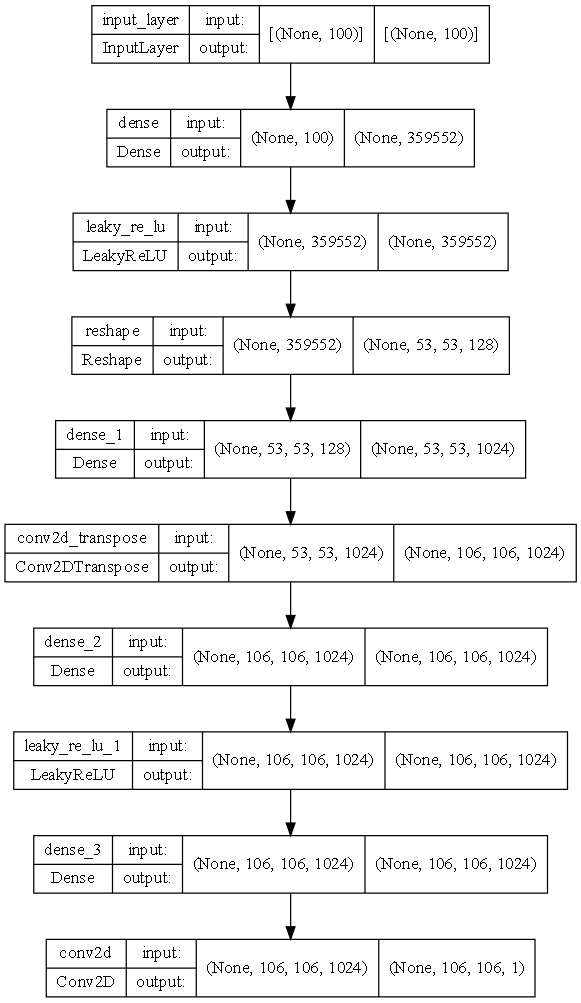

In [14]:
# plot the generated model
keras.utils.plot_model(g_model, show_shapes=True, dpi=90)

In [27]:
# # plot the generated model
# keras.utils.plot_model(d_model, show_shapes=True, dpi=90)

In [28]:
# # plot the generated model
# keras.utils.plot_model(gan_model, show_shapes=True, dpi=90)

In [15]:
# read in the training data
import random
random.seed(5634)

training_set = joblib.load('../data/piano-labelled/training_set.joblib')
training_set = random.sample(training_set, 2048) #5 is the lenth of the sample
# images, captions = zip(*training_set)
# images = np.array(images)
# captions = np.array(captions)
# images.shape, captions.shape

In [16]:
def generate_real_samples(dataset, n_samples):
    # slice the image and caption from the dataset
    # generate 'real' class labels (1)
    images, captions = zip(*dataset)
    images = np.array(images)
    captions = np.array(captions)
    ix = np.random.randint(0, images.shape[0], n_samples)
    X_img = images[ix]   
    X_cap = captions[ix]
    y = np.ones((n_samples, 1))
    return X_img, X_cap, y
 
def generate_latent_points(latent_dim, n_samples):
    x_input = np.random.randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

def generate_fake_samples(g_model, latent_dim, caption, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    X = g_model.predict(x_input)
    y = np.zeros((n_samples, 1))
    return X, y

In [17]:
# # generate samples and save as a plot and save the model
# def summarize_performance(step, g_model, gan_model, latent_dim, x_cap, n_samples=100):
# 	# prepare fake examples
# 	X, _ = generate_fake_samples(g_model, latent_dim, x_cap, n_samples)
#     # save plot
# 	# scale from [-1,1] to [0,1]
# 	X = (X + 1) / 2.0
# 	# plot images
# 	for i in range(100):
# 		# define subplot
# 		plt.subplot(10, 10, 1 + i)
# 		# turn off axis
# 		plt.axis('off')
# 		# plot raw pixel data
# 		plt.imshow(X[i, :, :, 0], cmap='gray_r')
# 	# save plot to file
# 	filename1 = 'generated_plot_%04d.png' % (step+1)
# 	plt.savefig(filename1)
# 	plt.close()
# 	# save the generator model
# 	filename2 = 'model_%04d.h5' % (step+1)
# 	g_model.save(filename2)
# 	# save the gan model
# 	filename3 = 'gan_model_%04d.h5' % (step+1)
# 	gan_model.save(filename3)
# 	print('>Saved: %s, %s, and %s' % (filename1, filename2, filename3))

In [18]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=50, n_batch=16):
    bat_per_epo = int(len(dataset) / n_batch)
    half_batch = int(n_batch / 2)
    for i in range(n_epochs):
        for j in range(bat_per_epo):
            # prepare a mini batch of real and fake sample
            X_img_real, x_cap_real, y_real = generate_real_samples(dataset, half_batch)
            X_img_fake, y_fake = generate_fake_samples(g_model, latent_dim, x_cap_real, half_batch)

            # print(X_img_real, X_img_fake)
            
            # use real caption input to generate a fake image
            # train the discriminator on fake images generate from real caption and a set of latent points
            X, y = np.vstack((X_img_real, X_img_fake)), np.vstack((y_real, y_fake))        
            d_loss, _ = d_model.train_on_batch(X, y)
            
            # print("Discriminator Loss: ", (d_loss, _))
            # prepare points in latent space and fetch some real caption input

            X_img_real_full, x_cap_real_full, y_real_full = generate_real_samples(dataset, n_batch)
            X_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = np.ones((n_batch, 1))

            # perform full batch training on e2e GAN model 
            # using the latent point and real caption as input
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))

            # test print the image
            # X = g_model.predict([X_gan, x_cap_real_full])
            # print(np.unique(X))

        if (i+1) % 2 == 0:
            # summarize_performance(i, g_model, d_model, dataset, latent_dim)
            clear_output()

In [19]:
train(g_model, d_model, gan_model, training_set, latent_dim, n_epochs=2)

In [22]:
# save the model
g_model.save('../models/mini-gan/caption_piano_generator_model.h5')
d_model.save('../models/mini-gan/caption_piano_discriminator_model.h5')
gan_model.save('../models/mini-gan/caption_piano_gan_model.h5')

In [23]:
# Load model
g_model = keras.models.load_model('../models/mini-gan/caption_piano_generator_model.h5')

In [32]:
# select a random row from the metadata to get the caption
row = midi_meta.sample(1, random_state=74)

# get a random image tokenize caption and actual caption
NLP_caption = row['caption_list'].values
caption = [np.array(a) for a in row['tokenized_captions'].values]
caption = np.array(caption)
NLP_caption, caption

(array(["the tempo slows down, making the valence decrease. the arousal, however, gets more intense because the sound get's louder. it'. the valence is not changing because the piece is static. the arousal is also not changing, because it is static."],
       dtype=object),
 array([[3452, 3053, 3031, 2758,  891, 3451, 1846, 3053, 3290,  738, 3451,
         3053,  199, 3451, 1467, 3451, 1289, 1970, 1563,  291]]))

In [21]:
def generate_latent_points(latent_dim, n_samples):
    x_input = np.random.randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input


# declare a latent space
latent_dim = 100
latent_points = generate_latent_points(latent_dim, 1)
latent_points.shape, #caption.shape

((1, 100),)

In [22]:
model = g_model
X = g_model.predict(latent_points)
array = np.array(X.reshape(106,106),dtype = np.uint8)
np.unique(array), X

(array([0, 1], dtype=uint8),
 array([[[[0.0000000e+00],
          [0.0000000e+00],
          [0.0000000e+00],
          ...,
          [0.0000000e+00],
          [0.0000000e+00],
          [0.0000000e+00]],
 
         [[0.0000000e+00],
          [0.0000000e+00],
          [0.0000000e+00],
          ...,
          [0.0000000e+00],
          [0.0000000e+00],
          [3.8861237e-34]],
 
         [[0.0000000e+00],
          [0.0000000e+00],
          [0.0000000e+00],
          ...,
          [0.0000000e+00],
          [0.0000000e+00],
          [0.0000000e+00]],
 
         ...,
 
         [[0.0000000e+00],
          [0.0000000e+00],
          [0.0000000e+00],
          ...,
          [0.0000000e+00],
          [0.0000000e+00],
          [0.0000000e+00]],
 
         [[0.0000000e+00],
          [0.0000000e+00],
          [0.0000000e+00],
          ...,
          [0.0000000e+00],
          [0.0000000e+00],
          [0.0000000e+00]],
 
         [[0.0000000e+00],
          [0.0000000e+00],
 

In [23]:
array*=255
new_image = Image.fromarray(array,'L')
new_image = new_image.save(f'../data/midi_reconstruction/images/captioned_piece_test_no_cap.png')

In [ ]:
# for i in range(len(X)):
#     array = np.array(X[i].reshape(106,106),dtype = np.uint8)
#     array*=255
#     new_image = Image.fromarray(array,'L')
#     new_image = new_image.save(f'../data/midi_reconstruction/images/captioned_piece_g40_{i}.png')

In [24]:
# reconvert MIDI images to MIDI files
image_path = "../data/midi_reconstruction/images/captioned_piece_test_no_cap.png"
output_path = "../data/midi_reconstruction"

img2midi_obj = img2midi(image_path, output_path, resolution=0.25)
img2midi_obj.convert_to_midi()

In [179]:
# run to cell to play
# stop the cell and run sp.stop to stop the music
from music21 import midi, converter, instrument, note, chord

mf = midi.MidiFile()
mf.open(f"{output_path}/music.mid")
mf.read()
mf.close()
s = midi.translate.midiFileToStream(mf)
sp = midi.realtime.StreamPlayer(s)
sp.play()

In [40]:
sp.stop

<bound method StreamPlayer.stop of <music21.midi.realtime.StreamPlayer object at 0x00000286182130D0>>